In [4]:
from bs4 import BeautifulSoup
from requests import get
from gensim.models import KeyedVectors

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx

import time
import re
import os
from pathlib import Path

In [14]:
DATA_DIR = 'data'
GRAPH_FILENAME = 'n_wiki_graph'

# we filter out these types of link selectors
CLEAN = [
  'a[id="top"]',
  'a[class="mw-selflink selflink"]',
  'a[class="image"]',
  'a[class="internal"]',
]

# we filter out these links
REM_LINKS = [
  r"(\/wiki\/File:\w+)",
  r"(\/wiki\/Special:\w+)",
  r"(\/wiki\/Template:\w+)",
  r"(\/wiki\/Category:\w+)",
  r"(\/wiki\/Portal:\w+)",
  r"(\/wiki\/Template_talk:\w+)",
  r"(\/wiki\/Help:\w+)",
  r"(\/wiki\/Wikipedia:\w+)",
  r"(^#\w+)",
]

# main page content selector
CONT_SEL = "div#content"

def get_title(page):
  return re.sub(r"\/", "_", page)

Getting list of top n articles: (rn n = 1000)

In [15]:
n = 1000
df = pd.read_csv("ten_k_most_viewed_pages.csv")
top_n = df.page.head(n)

In [27]:
# in case you wanna skip ahead
START_INDEX = 0
SLEEP_TIME_S = 2 # dont make less than 2, we dont wanna overwhelm wikipedia too much

n = top_n.size

for i, url in enumerate(top_n):
  if i < START_INDEX:
    continue

  print(f"{i} of {n} ({round((i / n) * 100, 2)}%) - Scraping {url}")

  # load the page as html with BeautifulSoup
  res = get(f'https://en.wikipedia.org/wiki/{url}')

  # check if we got baned :c
  if res.status_code != 200:
    print("We got got")
    break

  html = BeautifulSoup(res.text, 'html.parser')

  # save html page as string
  html_str = str(html.prettify())

  # replace bad characters in titles with underscores
  title = get_title(url)

  # save file
  f = open(f"{DATA_DIR}/pages/{title}.html", "w")
  f.write(html_str)
  f.close()

  # let's not overload wikipedia with requests here
  time.sleep(SLEEP_TIME_S)

0 of 1000 (0.0%) - Scraping Main_Page
1 of 1000 (0.1%) - Scraping -
2 of 1000 (0.2%) - Scraping Diego_Maradona
3 of 1000 (0.3%) - Scraping United_States_Senate
4 of 1000 (0.4%) - Scraping Jeffrey_Epstein
5 of 1000 (0.5%) - Scraping Omayra_Sánchez
6 of 1000 (0.6%) - Scraping Bible


KeyboardInterrupt: 

Building Graph: At the moment, we're only drawing edges from articles in the top 1000 to other articles in the top 1000.

In [28]:
files = os.scandir(path = f"./{DATA_DIR}/pages/")
n = len(list(files))

G = nx.DiGraph()

# list our downloaded files
files = os.scandir(path = f"./{DATA_DIR}/pages/")
# n = len(list(files))

for i, file in enumerate(files):
  # extract url from filename
  url = Path(file).stem

  print(f"{i} of {n} ({round((i / n) * 100, 2)}%) - Graphing {url}")

  # add the current page to the graph
  G.add_node(url)

  # load the page into memory
  f = open(file, "r")
  html = BeautifulSoup(f.read(), 'html.parser')
  f.close()

  # clean up unwanted elements from page
  for c in CLEAN:
    els = html.select(f"{CONT_SEL} {c}")
    for el in els:
      el.decompose()

  # further remove unwanted links
  links = html.select(f"{CONT_SEL} a")
  for link in links:
    # extract href from link
    href = link['href']

    # we are only interested in links that start with `/wiki/` and aren't in REM_LINKS
    if not any([re.match(regex, href) for regex in REM_LINKS]) and re.match(r"^\/wiki\/\w+", href):
      # extract href from link
      href = link['href']

      # this is the destination url
      url_ = re.sub(r"\/wiki\/", "", href)

      # we only add the destination url if it happens to be inside our links of interests
      if url_ in top_n.to_numpy():
        # add edge to graph
        G.add_edge(url, url_)

  # save our graph at other file
  if i % 3 == 0:
    nx.write_gml(G, f"{DATA_DIR}/{GRAPH_FILENAME}.gml")

nx.write_gml(G, f"{DATA_DIR}/{GRAPH_FILENAME}.gml")



0 of 1008 (0.0%) - Graphing Theodore_Roosevelt
1 of 1008 (0.1%) - Graphing New_York_City
2 of 1008 (0.2%) - Graphing Judy_Garland
3 of 1008 (0.3%) - Graphing David_Bowie
4 of 1008 (0.4%) - Graphing Tom_Holland_(actor)
5 of 1008 (0.5%) - Graphing Genghis_Khan
6 of 1008 (0.6%) - Graphing Outer_Banks_(TV_series)
7 of 1008 (0.69%) - Graphing Jason_Statham
8 of 1008 (0.79%) - Graphing Space_Jam:_A_New_Legacy
9 of 1008 (0.89%) - Graphing Kaley_Cuoco
10 of 1008 (0.99%) - Graphing Cameron_Boyce
11 of 1008 (1.09%) - Graphing Jennifer_Aniston
12 of 1008 (1.19%) - Graphing Kurt_Russell
13 of 1008 (1.29%) - Graphing Lily-Rose_Depp
14 of 1008 (1.39%) - Graphing List_of_United_States_cities_by_population
15 of 1008 (1.49%) - Graphing David_Perdue
16 of 1008 (1.59%) - Graphing YouTube_Premium
17 of 1008 (1.69%) - Graphing Argentina_national_football_team
18 of 1008 (1.79%) - Graphing George_V
19 of 1008 (1.88%) - Graphing Kurt_Cobain
20 of 1008 (1.98%) - Graphing Hong_Kong
21 of 1008 (2.08%) - Graphi

Printing:

In [29]:
print(G.number_of_nodes(), G.number_of_edges())

1008 25103


/var/folders/s8/0fnmd9vj14j1x29mdvkk0j9r0000gn/T/ipykernel_43656/3064791202.py:40: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(pc)


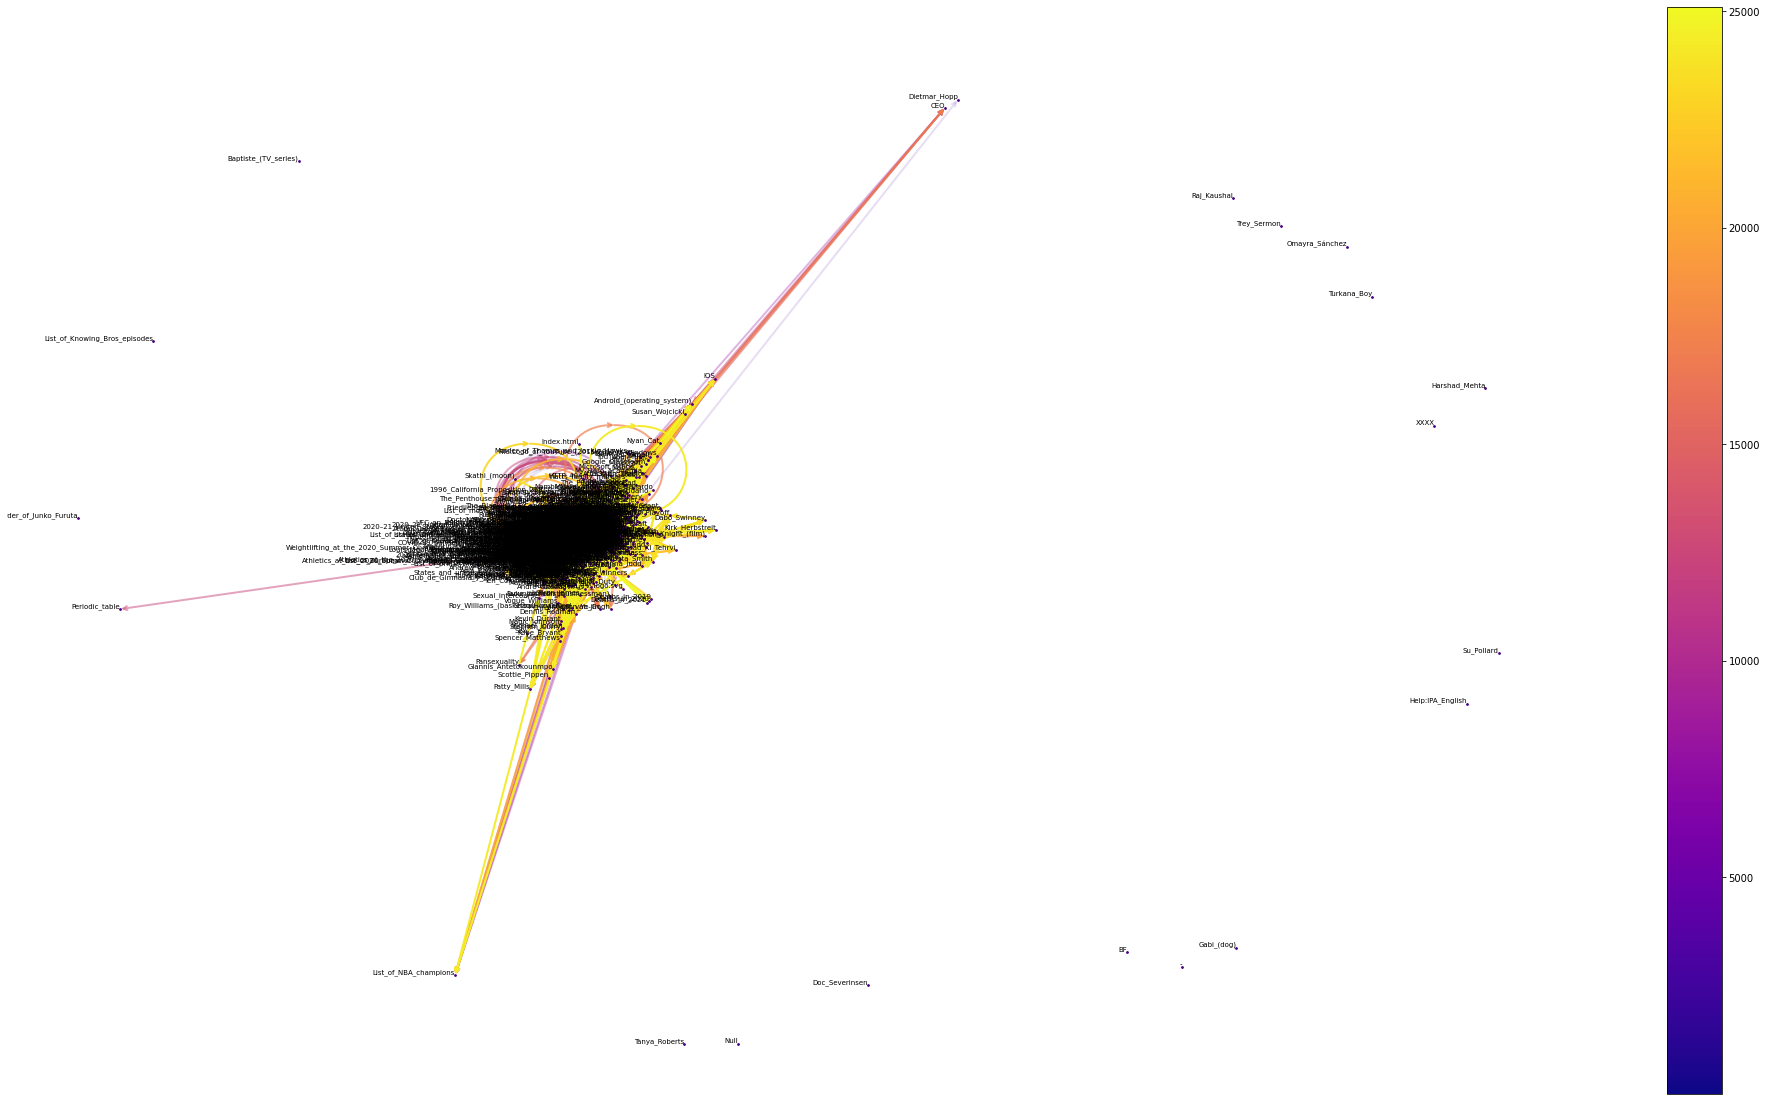

In [30]:
seed = 1337 # visual seed

# this spring layout allows us to position each edge in the graph, the seed simply ensures that the picture stays consistent
pos = nx.spring_layout(G, seed = seed)

# nodes are drawn different sizes based on importance
node_sizes = [3 + 10 * i for i in range(len(G))]
node_sizes = 3

M = G.number_of_edges()

# edge colors and alpha values are determined based on relation strength of nodes
edge_colors = range(2, M + 2)
edge_alphas = [(5 + i) / (M + 4) for i in range(M)]
cmap = plt.cm.plasma

# make our figure really large
plt.figure(3,figsize=(35,20)) 

nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes ,node_color="indigo")
edges = nx.draw_networkx_edges(
    G,
    pos,
    node_size=node_sizes,
    arrowstyle="->",
    arrowsize=10,
    edge_color=edge_colors,
    edge_cmap=cmap,
    width=2,
)
nx.draw_networkx_labels(G, pos, font_size=7, horizontalalignment='right', verticalalignment='bottom')

# set alpha value for each edge
for i in range(M):
    edges[i].set_alpha(edge_alphas[i])

# set colorbar on the side
pc = mpl.collections.PatchCollection(edges, cmap=cmap)
pc.set_array(edge_colors)
plt.colorbar(pc)

ax = plt.gca()
ax.set_axis_off()
plt.show()

Generate k article pairs from top n: 

In [20]:
MODEL_BIN = 'data/model/crawl-300d-2M.vec'
save_name = MODEL_BIN[:-4] + ".d2v"
# MODEL = KeyedVectors.load_word2vec_format(MODEL_BIN)
# MODEL.save(save_name)
MODEL = KeyedVectors.load(save_name)

model_keys = MODEL.index_to_key

def semanticSimilarity(w1, w2):
	w1_tokens = w1.split('_')
	w1_tokens = list(filter(lambda x: x in model_keys, w1_tokens))

	w2_tokens = w2.split('_')
	w2_tokens = list(filter(lambda x: x in model_keys, w2_tokens))

	return MODEL.n_similarity(w1_tokens, w2_tokens)


In [21]:
k = 5000
k_pairs = pd.DataFrame(columns=['start','end','wikiDistance','semanticSimilarity'])

G = nx.read_gml('data/n_wiki_graph.gml')

for i in range(k):
	temp = top_n.sample(n=2, random_state=i)
	start = temp.values[0]
	end = temp.values[1]

	if start not in list(G.nodes) or end not in list(G.nodes):
		continue

	if nx.has_path(G, start, end):
		dist = len(nx.shortest_path(G, start, end)) - 1
	else:
		dist = -1

	semSim = semanticSimilarity(start, end)

	k_pairs = k_pairs.append({'start':start, 'end':end, 'wikiDistance':dist, 'semanticSimilarity':semSim}, ignore_index=True)

k_pairs.head()

/var/folders/s8/0fnmd9vj14j1x29mdvkk0j9r0000gn/T/ipykernel_49589/2685002857.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  k_pairs = k_pairs.append({'start':start, 'end':end, 'wikiDistance':dist, 'semanticSimilarity':semSim}, ignore_index=True)
/var/folders/s8/0fnmd9vj14j1x29mdvkk0j9r0000gn/T/ipykernel_49589/2685002857.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  k_pairs = k_pairs.append({'start':start, 'end':end, 'wikiDistance':dist, 'semanticSimilarity':semSim}, ignore_index=True)
/var/folders/s8/0fnmd9vj14j1x29mdvkk0j9r0000gn/T/ipykernel_49589/2685002857.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  k_pairs = k_pairs.append({'start':start, 'end':end, 'wikiDistance':dist, 'semanticSimilarity':semSim},

ZeroDivisionError: At least one of the passed list is empty.

In [47]:
temp = top_n.sample(n=2, random_state=8)
type(temp.values[1])



str